In [38]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain


pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [3]:
path_to_data = '/data/projects/Comet/cwp140/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [4]:
## load AR scale
fname = path_to_data + 'preprocessed/MERRA2/MERRA2_ARScale_US-West.nc'
arscale = xr.open_dataset(fname)
arscale


ERROR 1: PROJ: proj_create_from_database: Open of /home/dnash/miniconda3/envs/eaton-scripps/share/proj failed


<xarray.Dataset>
Dimensions:   (time: 117608, lat: 67, lon: 34)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 ... 2020-03-31T21:00:00
  * lat       (lat) float64 27.0 27.5 28.0 28.5 29.0 ... 58.5 59.0 59.5 60.0
  * lon       (lon) float64 -140.0 -139.4 -138.8 -137.5 ... -115.6 -114.4 -113.8
Data variables:
    ivt       (lat, lon, time) float64 ...
    ar_scale  (lat, lon, time) float64 ...
    tIVT      (lat, lon, time) float64 ...
    duration  (lat, lon, time) float64 ...

In [11]:
## load watershed trajectory
fname = '/home/dnash/comet_data/preprocessed/ERA5_trajectories/PRISM_HUC8_14080107.nc'
ERA5 = xr.open_dataset(fname)
## start with one trajectory, then loop all
ERA5 = ERA5.isel(start_date=10)
ERA5

<xarray.Dataset>
Dimensions:       (index: 72)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
    start_date    datetime64[ns] 2004-01-03
Data variables:
    time          (index) datetime64[ns] ...
    latitude      (index) float64 ...
    longitude     (index) float64 ...
    level         (index) float64 ...
    q             (index) float64 ...
    u             (index) float64 ...
    v             (index) float64 ...
    w             (index) float64 ...
    dq            (index) float64 ...
    drying_ratio  (index) float64 ...

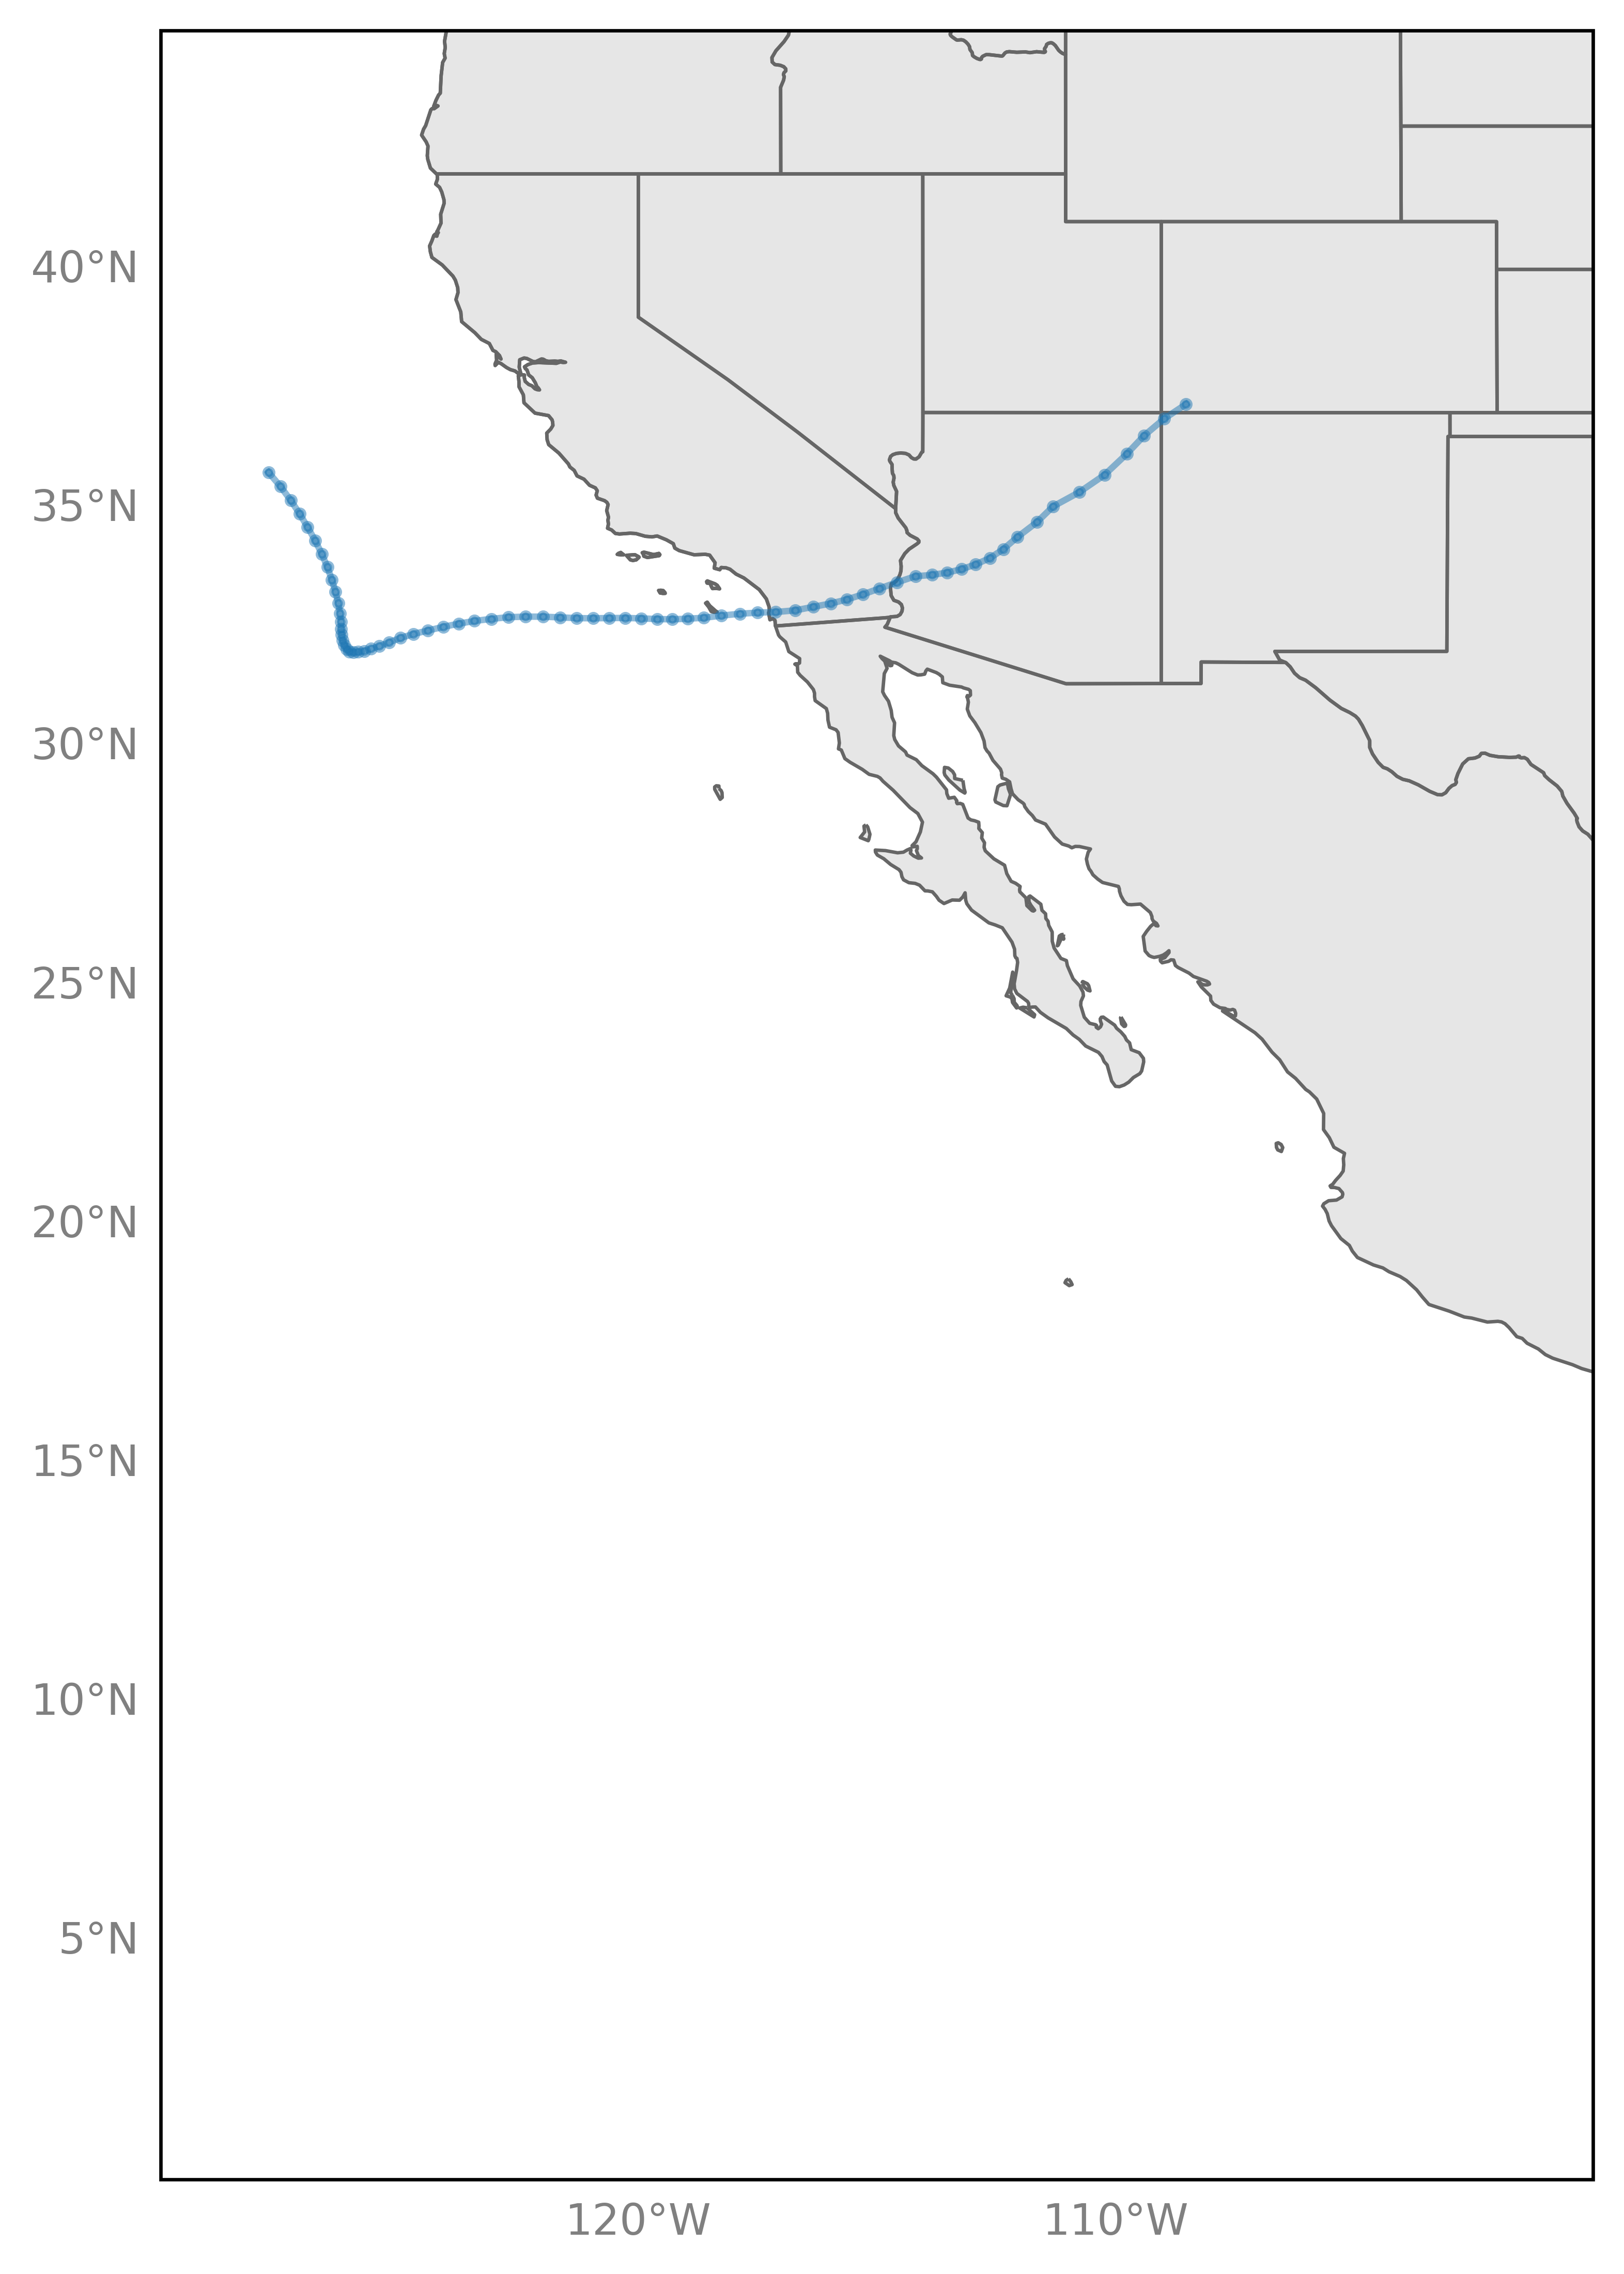

In [45]:
ext = [-130., -100., 0., 45.] 
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

fig = plt.figure(figsize=(9.0 ,9.0))
fig.dpi = 600
fname = path_to_figs + 'test_trajectory'

ax = plt.axes(projection=mapcrs)
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
ax.set_extent(ext, datacrs)

ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)

# need this to fix annotate transform
transform = datacrs._as_mpl_transform(ax)
# ax.plot(arscale.lon.values, arscale.lat.values, 'o', 'k', markersize=2, transform=datacrs, alpha=0.5)

## Add different points
for i in range(1):
    data = ERA5
    y_lst = data.latitude.values
    x_lst = data.longitude.values
    ax.plot(x_lst, y_lst, 'o-', 'red', markersize=2, transform=datacrs, alpha=0.5)

## Add elevation contours
# ax = plot_terrain(ax, ext)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [50]:
def find_closest_MERRA2_lon(lon):
    ## MERRA2 longitudes are every 0.625 degree
    merra2_lons = np.arange(-180.0, 180., 0.625)
    
    myList = merra2_lons
    myNumber = lon
    final = min(myList, key=lambda x:abs(x-myNumber))
    
    return final

In [51]:
new_lst = []
for lon in ERA5.longitude.values:
    new_lst.append(find_closest_MERRA2_lon(lon))

In [53]:
x

<xarray.DataArray (location: 72)>
array([-108.75 , -108.75 , -109.375, -110.   , -110.   , -110.625,
       -111.25 , -111.875, -111.875, -112.5  , -112.5  , -113.125,
       -113.125, -113.75 , -113.75 , -114.375, -114.375, -115.   ,
       -115.   , -115.625, -116.25 , -116.25 , -116.875, -116.875,
       -117.5  , -118.125, -118.125, -118.75 , -118.75 , -119.375,
       -119.375, -120.   , -120.   , -120.625, -121.25 , -121.25 ,
       -121.875, -121.875, -122.5  , -122.5  , -123.125, -123.125,
       -123.75 , -124.375, -124.375, -125.   , -125.   , -125.   ,
       -125.625, -125.625, -125.625, -125.625, -126.25 , -126.25 ,
       -126.25 , -126.25 , -126.25 , -126.25 , -126.25 , -126.25 ,
       -126.25 , -126.25 , -126.25 , -126.25 , -126.25 , -126.875,
       -126.875, -126.875, -126.875, -127.5  , -127.5  , -127.5  ])
Dimensions without coordinates: location

In [54]:
y

<xarray.DataArray (location: 72)>
array([37. , 37. , 36.5, 36. , 35.5, 35.5, 35. , 34.5, 34.5, 34. , 34. ,
       34. , 33.5, 33.5, 33.5, 33.5, 33.5, 33.5, 33. , 33. , 33. , 33. ,
       33. , 33. , 33. , 33. , 33. , 32.5, 32.5, 32.5, 32.5, 32.5, 32.5,
       32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5, 32.5,
       32.5, 32.5, 32.5, 32. , 32. , 32. , 32. , 32. , 32. , 32. , 32. ,
       32. , 32. , 32.5, 32.5, 32.5, 33. , 33. , 33. , 33.5, 34. , 34. ,
       34.5, 34.5, 35. , 35. , 35.5, 36. ])
Dimensions without coordinates: location

In [56]:
## create a list of lat/lons that match MERRA2 spacing
## lat and lon points from trajectory
x = xr.DataArray(new_lst, dims=['location'])
y = xr.DataArray(round_off_rating(ERA5.latitude.values), dims=['location'])

## select the points from arscale data that match exact (switch 'nearest' to None)
arscale.sel(lon=x, lat=y, method="nearest", drop=True)

<xarray.Dataset>
Dimensions:   (time: 117608, location: 72)
Coordinates:
  * time      (time) datetime64[ns] 1980-01-01 ... 2020-03-31T21:00:00
    lat       (location) float64 37.0 37.0 36.5 36.0 ... 35.0 35.0 35.5 36.0
    lon       (location) float64 -113.8 -113.8 -113.8 ... -127.5 -127.5 -127.5
Dimensions without coordinates: location
Data variables:
    ivt       (location, time) float64 ...
    ar_scale  (location, time) float64 ...
    tIVT      (location, time) float64 ...
    duration  (location, time) float64 ...

In [47]:
x

<xarray.DataArray (location: 72)>
array([-108.52883135, -108.98741424, -109.40539512, -109.76725223,
       -110.23392872, -110.75745825, -111.31549081, -111.65244962,
       -112.06213788, -112.35443161, -112.63774492, -112.93954293,
       -113.23079416, -113.52911707, -113.84488586, -114.19790697,
       -114.57814933, -114.95072153, -115.29582975, -115.63603012,
       -115.9654561 , -116.33841237, -116.71093027, -117.12239051,
       -117.50632648, -117.87641557, -118.25925877, -118.63294967,
       -118.96531601, -119.28812195, -119.6079665 , -119.9376187 ,
       -120.27685701, -120.61515783, -120.94879097, -121.28773685,
       -121.6390101 , -122.00001082, -122.36500821, -122.72270545,
       -123.08172081, -123.43047262, -123.76402225, -124.08857047,
       -124.40556277, -124.71128858, -124.98724153, -125.22370402,
       -125.4253202 , -125.59841829, -125.74026545, -125.86665855,
       -125.97268351, -126.05146927, -126.10825047, -126.16114423,
       -126.19715015, -126.21509123, -126.22369615, -126.22928157,
       -126.24736265, -126.28478979, -126.34146837, -126.4201643 ,
       -126.51327175, -126.62933098, -126.76954785, -126.92888941,
       -127.09549265, -127.28215013, -127.49850794, -127.74484373])
Dimensions without coordinates: location

In [17]:
def round_off_rating(number):
    """Round a number to the closest half integer.
    >>> round_off_rating(1.3)
    1.5
    >>> round_off_rating(2.6)
    2.5
    >>> round_off_rating(3.0)
    3.0
    >>> round_off_rating(4.1)
    4.0"""

    return np.round(number * 2) / 2

In [29]:
arrays = [round_off_rating(ERA5.latitude.values), round_off_rating(ERA5.longitude.values)]
tuples = list(zip(*arrays))
idx1 = pd.MultiIndex.from_tuples(tuples, names=["lat", "lon"])

arrays = [arscale.lat.values, arscale.lon.values]
tuples = list(zip(*arrays))
idx2 = pd.MultiIndex.from_tuples(tuples, names=["lat", "lon"])

In [42]:
idx2.intersection(idx1)

MultiIndex([], names=['lat', 'lon'])

In [43]:
idx2

MultiIndex([(27.0,   -140.0),
            (27.5, -139.375),
            (28.0,  -138.75),
            (28.5,   -137.5),
            (29.0,  -136.25),
            (29.5, -135.625),
            (30.0,   -135.0),
            (30.5, -134.375),
            (31.0,  -133.75),
            (31.5, -133.125),
            (32.0, -130.625),
            (32.5,   -130.0),
            (33.0, -129.375),
            (33.5,  -128.75),
            (34.0, -128.125),
            (34.5,   -127.5),
            (35.0, -126.875),
            (35.5,  -126.25),
            (36.0,   -125.0),
            (36.5, -124.375),
            (37.0,  -123.75),
            (37.5, -123.125),
            (38.0,   -122.5),
            (38.5, -121.875),
            (39.0,  -121.25),
            (39.5, -120.625),
            (40.0,   -120.0),
            (40.5,  -118.75),
            (41.0,   -117.5),
            (41.5, -116.875),
            (42.0,  -116.25),
            (42.5, -115.625),
            (43.0, -114.375),
          